# Python Jupyter Notebook

IMPORTING THE REQIURED LIBRARIES 

In [9]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold,SelectKBest,mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



READING THE CSV FILE INTO A DATAFRAME

In [11]:
csv_file = 'openml_1067_dataset.csv'  
df_csv = pd.read_csv(csv_file)
print("Total rows in CSV file:", df_csv.shape[0])
print("\nFirst 5 rows from CSV:")
print(df_csv.head())


Total rows in CSV file: 2109

First 5 rows from CSV:
    loc  v(g)  ev(g)  iv(g)      n       v     l      d      i         e  ...  \
0   1.1   1.4    1.4    1.4    1.3    1.30  1.30   1.30   1.30      1.30  ...   
1   1.0   1.0    1.0    1.0    1.0    1.00  1.00   1.00   1.00      1.00  ...   
2  83.0  11.0    1.0   11.0  171.0  927.89  0.04  23.04  40.27  21378.61  ...   
3  46.0   8.0    6.0    8.0  141.0  769.78  0.07  14.86  51.81  11436.73  ...   
4  25.0   3.0    1.0    3.0   58.0  254.75  0.11   9.35  27.25   2381.95  ...   

   lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
0     2.0          2        2                  2      1.2        1.2   
1     1.0          1        1                  1      1.0        1.0   
2    65.0         10        6                  0     18.0       25.0   
3    37.0          2        5                  0     16.0       28.0   
4    21.0          0        2                  0     11.0       10.0   

   total_Op  total_Opnd  br

Connect to the database and insert CSV data


In [13]:
conn = sqlite3.connect('normalized_project.db')
cursor = conn.cursor()

In [14]:
cursor.execute('DROP TABLE IF EXISTS MainData')

In [19]:
# Creating the table based on CSV columns
df_csv_columns = ', '.join([f'"{col}" REAL' for col in df_csv.columns if col != 'defects'])
create_table_query = f'''
CREATE TABLE MainData (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    {df_csv_columns},
    "defects" TEXT
)
'''

In [21]:
original_header = df_csv.columns
sanitized_header = [col.replace("(", "_").replace(")", "_").replace(" ", "_") for col in original_header]

# Drop table if it exists to avoid duplication
cursor.execute('DROP TABLE IF EXISTS MainData')

# Create the table using sanitized column headers
create_table_query = f'''
CREATE TABLE MainData (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    {', '.join([f'"{col}" REAL' for col in sanitized_header[:-1]])},  -- All features except the target
    "defects" TEXT                                      -- Target column
)
'''
cursor.execute(create_table_query)

In [23]:
# Inserting data into the database
df_csv.to_sql('MainData', conn, if_exists='replace', index=False)
print("\nData successfully inserted into the database.")



Data successfully inserted into the database.


In [25]:
# Fetching the data using SQL join into DataFrame
query = "SELECT * FROM MainData"
df = pd.read_sql_query(query, conn)



In [27]:
# Fetch the data using SQL join into DataFrame and ensuring 'id' col in included
query = "SELECT rowid AS id, * FROM MainData"  
df = pd.read_sql_query(query, conn)
conn.close()

In [29]:
print("\nTotal rows in DataFrame after SQL Join:", df.shape[0])
print("\nFirst 5 rows:")
print(df.head())



Total rows in DataFrame after SQL Join: 2109

First 5 rows:
   id   loc  v(g)  ev(g)  iv(g)      n       v     l      d      i  ...  \
0   1   1.1   1.4    1.4    1.4    1.3    1.30  1.30   1.30   1.30  ...   
1   2   1.0   1.0    1.0    1.0    1.0    1.00  1.00   1.00   1.00  ...   
2   3  83.0  11.0    1.0   11.0  171.0  927.89  0.04  23.04  40.27  ...   
3   4  46.0   8.0    6.0    8.0  141.0  769.78  0.07  14.86  51.81  ...   
4   5  25.0   3.0    1.0    3.0   58.0  254.75  0.11   9.35  27.25  ...   

   lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
0     2.0          2        2                  2      1.2        1.2   
1     1.0          1        1                  1      1.0        1.0   
2    65.0         10        6                  0     18.0       25.0   
3    37.0          2        5                  0     16.0       28.0   
4    21.0          0        2                  0     11.0       10.0   

   total_Op  total_Opnd  branchCount  defects  
0      

Checking for missing values and target distribution


In [32]:

print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


In [34]:
print("\nTarget Value Distribution:")
print(df['defects'].value_counts())


Target Value Distribution:
defects
0    1783
1     326
Name: count, dtype: int64


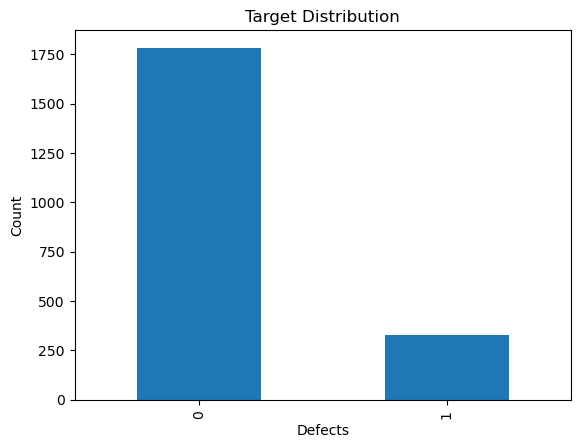

In [36]:
df['defects'].value_counts().plot(kind='bar', title='Target Distribution')
plt.xlabel('Defects')
plt.ylabel('Count')
plt.show()

Performing Train/Test Split with Stratification


In [39]:
X = df.drop(['id', 'defects'], axis=1)
y = df['defects']

In [41]:
# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [43]:
print("\nTrain Set Size:", X_train.shape[0])
print("Test Set Size:", X_test.shape[0])

print("\nTrain Target Distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest Target Distribution:")
print(y_test.value_counts(normalize=True))

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("\nTrain and Test sets have been saved as CSV files.")


Train Set Size: 1687
Test Set Size: 422

Train Target Distribution:
defects
0    0.845287
1    0.154713
Name: proportion, dtype: float64

Test Target Distribution:
defects
0    0.845972
1    0.154028
Name: proportion, dtype: float64

Train and Test sets have been saved as CSV files.


In [45]:
# Generate a correlation matrix
print("\nCorrelation Matrix:")
correlation_matrix = df.corr()
print(correlation_matrix)


Correlation Matrix:
                         id       loc      v(g)     ev(g)     iv(g)         n  \
id                 1.000000 -0.263497 -0.221279 -0.145884 -0.224694 -0.272575   
loc               -0.263497  1.000000  0.902619  0.718833  0.895167  0.948510   
v(g)              -0.221279  0.902619  1.000000  0.819965  0.965689  0.922511   
ev(g)             -0.145884  0.718833  0.819965  1.000000  0.775740  0.746253   
iv(g)             -0.224694  0.895167  0.965689  0.775740  1.000000  0.893768   
n                 -0.272575  0.948510  0.922511  0.746253  0.893768  1.000000   
v                 -0.254446  0.938516  0.915556  0.753569  0.884920  0.994956   
l                  0.211925 -0.432179 -0.379873 -0.260710 -0.369299 -0.412032   
d                 -0.288405  0.846844  0.868341  0.698391  0.815358  0.891586   
i                 -0.297805  0.802832  0.673304  0.511383  0.674493  0.826783   
e                 -0.188247  0.821338  0.862413  0.738864  0.807287  0.908211   
b      

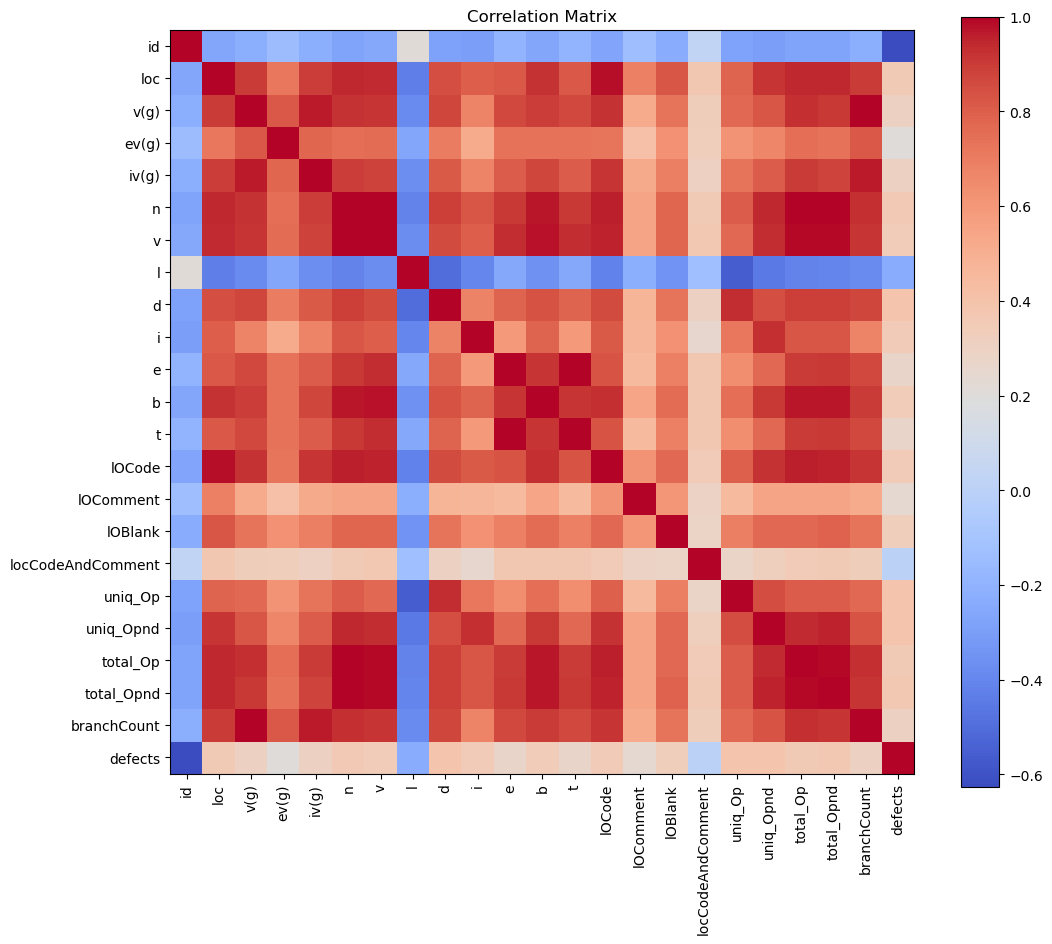

In [47]:
plt.figure(figsize=(12, 10))
plt.title("Correlation Matrix")
corr_plot = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(corr_plot)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

DATA CLEANING

In [50]:
#Remove low-variance features from training and testing sets

low_variance_cols = [col for col in X_train.columns if X_train[col].std() < 0.01]
X_train.drop(columns=low_variance_cols, inplace=True)
X_test.drop(columns=low_variance_cols, inplace=True)
print(f"Removed low-variance columns: {low_variance_cols}")

Removed low-variance columns: []


In [52]:
#Remove highly correlated features from training and testing sets

correlation_matrix = X_train.corr()
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
X_train.drop(columns=correlated_features, inplace=True)
X_test.drop(columns=correlated_features, inplace=True)
print(f"Removed highly correlated features: {correlated_features}")

Removed highly correlated features: {'b', 't', 'uniq_Opnd', 'd', 'v', 'branchCount', 'iv(g)', 'lOCode', 'total_Op', 'v(g)', 'e', 'total_Opnd', 'n', 'uniq_Op'}


In [54]:
#Handle outliers in training and testing sets

z_scores = X_train.select_dtypes(include=['float64', 'int64']).apply(zscore)
X_train = X_train[(z_scores < 3).all(axis=1)]
y_train = y_train[X_train.index]  # Ensure alignment of target labels

z_scores_test = X_test.select_dtypes(include=['float64', 'int64']).apply(zscore)
X_test = X_test[(z_scores_test < 3).all(axis=1)]
y_test = y_test[X_test.index]
print("Outliers handled in training and testing sets.")


Outliers handled in training and testing sets.


In [56]:
# Normalize numeric features in training and testing sets
scaler = MinMaxScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
print("Numeric features normalized in training and testing sets.")

Numeric features normalized in training and testing sets.


In [58]:
print("\nTrain Set Size:", X_train.shape[0])
print("Test Set Size:", X_test.shape[0])


Train Set Size: 1565
Test Set Size: 385


In [85]:
import dagshub
dagshub.init(repo_owner='atluribhumika08',
             repo_name='Code_Defect_Detection_Project',
             mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)

Initialized MLflow to track repo "atluribhumika08/Code_Defect_Detection_Project"

Repository atluribhumika08/Code_Defect_Detection_Project initialized!

🏃 View run rogue-moose-349 at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9/runs/6203d10803e34409b048743a328fe142
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9


In [87]:
# Define preprocessing steps
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p, validate=True))
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [89]:
# Define Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

In [91]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

In [93]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'liblinear']
}

In [95]:
# Perform hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('minmax',
                                                                                          MinMaxScaler()),
                                                                                         ('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              validate=True))]),
                                                                         Index(['loc', 'ev(g)', 'l', 'i', 'lOComment', 'lOBlank', 'locCodeAndComment'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index([], dtype='object'))])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='f1_weighted', verbose=1)

In [97]:
# Best model after hyperparameter tuning
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}


In [99]:
# Cross-validation with the best model
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='f1_weighted')
print("CV F1-Score (mean):", cv_scores.mean())
print("CV F1-Score (std):", cv_scores.std())

CV F1-Score (mean): 0.8112533936138251
CV F1-Score (std): 0.014845632976922561


In [101]:
# Evaluate on the test set
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
else:
    tn = fp = fn = tp = 0

print("Test F1-Score:", f1)
print("Confusion Matrix (TP, TN, FP, FN):", (tp, tn, fp, fn))

Test F1-Score: 0.8108721576757222
Confusion Matrix (TP, TN, FP, FN): (2, 329, 5, 49)


In [103]:
# Log results in MLFlow
dags_url = "https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow"
os.environ['MLFLOW_TRACKING_URI'] = dags_url
mlflow.set_experiment("Experiment 1 ")

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("Best C", grid_search.best_params_['classifier__C'])
    mlflow.log_param("Best Solver", grid_search.best_params_['classifier__solver'])

    # Log metrics
    mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
    mlflow.log_metric("std_cv_f1_score", cv_scores.std())
    mlflow.log_metric("test_f1_score", f1)
    mlflow.log_metric("tp", tp)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)

    # Log model
    mlflow.sklearn.log_model(best_model, "model")

print("Experiment completed and logged in MLFlow.")


2024/12/20 20:29:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run invincible-pig-113 at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/8/runs/7c47fccd429e49d49fd18083b0ddf9a0
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/8
Experiment completed and logged in MLFlow.


Experiment #2: Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier, RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.

In [105]:
# Define classifiers
classifiers = {
    "EX2 - Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "EX2 - Ridge Classifier": RidgeClassifier(random_state=42),
    "EX2 - Random Forest": RandomForestClassifier(random_state=42),
    "EX2 - XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [108]:
# MLFlow experiment setup
mlflow.set_experiment("Experiment 2 ")

# Train and evaluate each classifier
results = []
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}")

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_weighted')

    # Train and evaluate on the test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    # Log results in MLFlow
    with mlflow.start_run(run_name=name):
        mlflow.log_param("Classifier", name)
        mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
        mlflow.log_metric("std_cv_f1_score", cv_scores.std())
        mlflow.log_metric("test_f1_score", f1)
        mlflow.log_metric("tp", tp)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)

        # Log model
        mlflow.sklearn.log_model(pipeline, "model")

    # Store results
    results.append({
        "Classifier": name,
        "Mean CV F1-Score": cv_scores.mean(),
        "Std CV F1-Score": cv_scores.std(),
        "Test F1-Score": f1
    })

# Display results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)

Training and evaluating EX2 - Logistic Regression


2024/12/20 20:30:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run EX2 - Logistic Regression at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9/runs/290209310bdd482bb1053295ead6f36b
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9
Training and evaluating EX2 - Ridge Classifier


2024/12/20 20:30:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run EX2 - Ridge Classifier at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9/runs/fe405187a97d42048eb7db9a3e14e160
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9
Training and evaluating EX2 - Random Forest


2024/12/20 20:30:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run EX2 - Random Forest at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9/runs/7bafdb98d8e14f9e84ba46b25f7836f0
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9
Training and evaluating EX2 - XGBoost


2024/12/20 20:31:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run EX2 - XGBoost at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9/runs/871e3b7bba20415eac3943e548aef8fc
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/9

Summary of Results:
                  Classifier  Mean CV F1-Score  Std CV F1-Score  Test F1-Score
0  EX2 - Logistic Regression          0.812057         0.016030       0.806652
1     EX2 - Ridge Classifier          0.806034         0.013403       0.806652
2        EX2 - Random Forest          0.826556         0.019823       0.856334
3              EX2 - XGBoost          0.836847         0.022815       0.844589


Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.

In [110]:
# Feature engineering function
def feature_engineering(X):
    """Create new features and transform existing ones."""

    X_new = X.copy()

    # Safely create new features based on available columns
    if 'loc' in X_new.columns and 'total_Op' in X_new.columns:
        X_new['loc_to_total_Op'] = X_new['loc'] / (X_new['total_Op'] + 1e-5)
    if 'v' in X_new.columns and 'ev(g)' in X_new.columns:
        X_new['v_to_ev'] = X_new['v'] / (X_new['ev(g)'] + 1e-5)
    if 'total_Op' in X_new.columns and 'total_Opnd' in X_new.columns:
        X_new['total_operations'] = X_new['total_Op'] + X_new['total_Opnd']

    # Log transformations for skewed features
    for col in ['v', 'e', 'branchCount']:
        if col in X_new.columns:
            X_new[f'log_{col}'] = np.log1p(X_new[col])

    return X_new

In [111]:
# Preprocessing pipeline with feature engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), slice(0, X_train.shape[1]))
    ]
)


In [112]:
# Define classifiers
classifiers = {
    "EX3 - Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "EX3 - Ridge Classifier": RidgeClassifier(random_state=42),
    "EX3 - Random Forest": RandomForestClassifier(random_state=42),
    "EX3 - XGBoost": XGBClassifier( eval_metric='logloss', random_state=42)
}

In [117]:
# MLFlow experiment setup
mlflow.set_experiment("Experiment 3 - Feature Engineering")

# Train and evaluate each classifier
results = []
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}...")

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('feature_engineering', FunctionTransformer(feature_engineering, validate=False)),
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_weighted')

        # Train and evaluate on the test set
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Metrics
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        # Log results in MLFlow
        with mlflow.start_run(run_name=name):
            mlflow.log_param("Classifier", name)
            mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
            mlflow.log_metric("std_cv_f1_score", cv_scores.std())
            mlflow.log_metric("test_f1_score", f1)
            mlflow.log_metric("tp", tp)
            mlflow.log_metric("tn", tn)
            mlflow.log_metric("fp", fp)
            mlflow.log_metric("fn", fn)

        # Store results
        results.append({
            "Classifier": name,
            "Mean CV F1-Score": cv_scores.mean(),
            "Std CV F1-Score": cv_scores.std(),
            "Test F1-Score": f1
        })

    except ValueError as e:
        print(f"Error while processing {name}: {e}")

# Display results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


Training and evaluating EX3 - Logistic Regression...
🏃 View run EX3 - Logistic Regression at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/3/runs/320c111bcf524c2b8ad4e5245e564a0f
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/3
Training and evaluating EX3 - Ridge Classifier...
🏃 View run EX3 - Ridge Classifier at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/3/runs/2f25b6220a1a4ffc9f083704a04f7dc4
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/3
Training and evaluating EX3 - Random Forest...
🏃 View run EX3 - Random Forest at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/3/runs/11739423eaa341e8a31464c2c20cea68
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/3
Training and evaluatin

Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold. Log results in MLFlow.

In [119]:
# Feature selection function
def feature_selection(X, y):
    """Perform feature selection using variance, correlation, and feature importance."""
    X_new = X.copy()

    # 1. Variance Threshold
    variance_selector = VarianceThreshold(threshold=0.01)  # Remove low variance features
    X_var = variance_selector.fit_transform(X_new)
    selected_features_var = X.columns[variance_selector.get_support()]

    # 2. Correlation Threshold (for demonstration, remove highly correlated features)
    correlation_matrix = pd.DataFrame(X_var, columns=selected_features_var).corr()
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.9:  # Threshold
                correlated_features.add(correlation_matrix.columns[i])
    X_corr = pd.DataFrame(X_var, columns=selected_features_var).drop(columns=correlated_features, errors='ignore')

    # 3. Feature Importance using Mutual Information
    mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
    mi_selector.fit(X_corr, y)
    feature_scores = pd.DataFrame({
        'Feature': X_corr.columns,
        'Importance': mi_selector.scores_
    }).sort_values(by='Importance', ascending=False)

    # Keep top features based on mutual information (e.g., top 10 features)
    top_features = feature_scores.nlargest(10, 'Importance')['Feature']
    X_selected = X_corr[top_features]

    return X_selected, top_features




In [120]:
# Perform feature selection
X_train_selected, selected_features = feature_selection(X_train, y_train)
X_test_selected = X_test[selected_features]

print(selected_features)

0                  loc
3                    i
2                    l
5              lOBlank
1                ev(g)
4            lOComment
6    locCodeAndComment
Name: Feature, dtype: object


In [121]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ]
)

In [122]:
# Define classifiers
classifiers = {
    "EX4 - Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "EX4 - Random Forest": RandomForestClassifier(random_state=42),
    "EX4 - XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [123]:
# MLFlow experiment setup
mlflow.set_experiment("Experiment 4 ")

# Train and evaluate each classifier
results = []
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}...")

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        cv_scores = cross_val_score(pipeline, X_train_selected, y_train, cv=skf, scoring='f1_weighted')

        # Train and evaluate on the test set
        pipeline.fit(X_train_selected, y_train)
        y_pred = pipeline.predict(X_test_selected)

        # Metrics
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        # Log results in MLFlow
        with mlflow.start_run(run_name=name):
            mlflow.log_param("Classifier", name)
            mlflow.log_param("Selected Features", list(selected_features))
            mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
            mlflow.log_metric("std_cv_f1_score", cv_scores.std())
            mlflow.log_metric("test_f1_score", f1)
            mlflow.log_metric("tp", tp)
            mlflow.log_metric("tn", tn)
            mlflow.log_metric("fp", fp)
            mlflow.log_metric("fn", fn)

        # Store results
        results.append({
            "Classifier": name,
            "Mean CV F1-Score": cv_scores.mean(),
            "Std CV F1-Score": cv_scores.std(),
            "Test F1-Score": f1
        })

    except ValueError as e:
        print(f"Error while processing {name}: {e}")

# Display results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


Training and evaluating EX4 - Logistic Regression...
🏃 View run EX4 - Logistic Regression at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/10/runs/90ebf807ceb049b4a70fee789da21e43
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/10
Training and evaluating EX4 - Random Forest...
🏃 View run EX4 - Random Forest at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/10/runs/2adc1221cd8a4377ae84cd6ffa19b6b3
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/10
Training and evaluating EX4 - XGBoost...
🏃 View run EX4 - XGBoost at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/10/runs/3bd4444c6fe7475eb713b5c6467da0f3
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/10

Summary of Results:
             

Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. Log results in MLFlow.

In [125]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [126]:
# Apply PCA for dimensionality reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

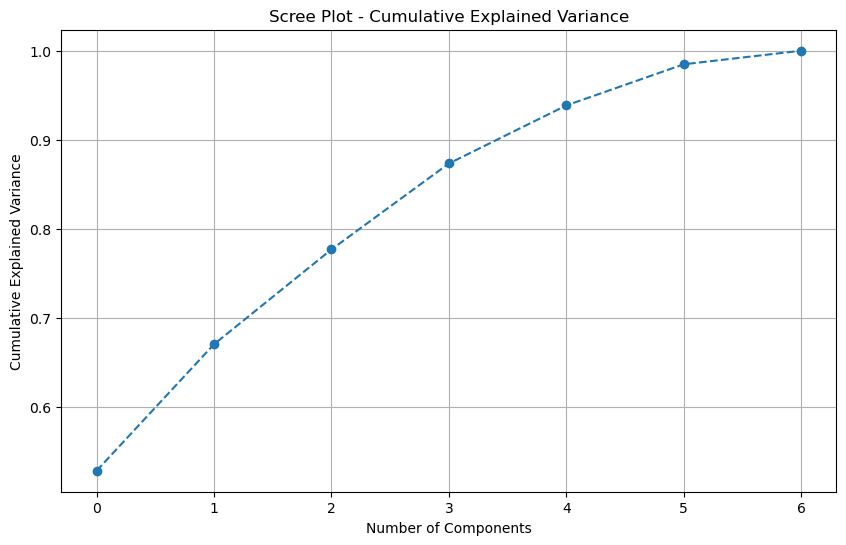

In [132]:
# Scree plot to determine the number of components
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Scree Plot - Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.savefig("scree_plot.png")  # Save the plot
plt.show()

In [133]:
# Select the number of components to retain (e.g., 95% variance)
n_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f"Number of components selected: {n_components}")


Number of components selected: 6


In [134]:
# Reduce dimensionality with selected components
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [135]:
classifiers = {
    "EX5 - Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "EX5 - Random Forest": RandomForestClassifier(random_state=42),
    "EX5 - XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [136]:
# MLFlow experiment setup
mlflow.set_experiment("Experiment 5 - PCA ")

# Train and evaluate each classifier
results = []
for name, clf in classifiers.items():
    print(f"Training and evaluating {name}...")

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        cv_scores = cross_val_score(clf, X_train_reduced, y_train, cv=skf, scoring='f1_weighted')

        # Train and evaluate on the test set
        clf.fit(X_train_reduced, y_train)
        y_pred = clf.predict(X_test_reduced)

        # Metrics
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        # Log results in MLFlow
        with mlflow.start_run(run_name=name):
            mlflow.log_param("Classifier", name)
            mlflow.log_param("Number of Components", n_components)
            mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
            mlflow.log_metric("std_cv_f1_score", cv_scores.std())
            mlflow.log_metric("test_f1_score", f1)
            mlflow.log_metric("tp", tp)
            mlflow.log_metric("tn", tn)
            mlflow.log_metric("fp", fp)
            mlflow.log_metric("fn", fn)

            # Log scree plot
            mlflow.log_artifact("scree_plot.png", artifact_path="plots")

        # Store results
        results.append({
            "Classifier": name,
            "Mean CV F1-Score": cv_scores.mean(),
            "Std CV F1-Score": cv_scores.std(),
            "Test F1-Score": f1
        })

    except ValueError as e:
        print(f"Error while processing {name}: {e}")

# Display results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)

Training and evaluating EX5 - Logistic Regression...
🏃 View run EX5 - Logistic Regression at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/11/runs/050ca3641c74455f9f7b470d316bf2c4
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/11
Training and evaluating EX5 - Random Forest...
🏃 View run EX5 - Random Forest at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/11/runs/97f80513060e43d9b31f6c5f2fcc291e
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/11
Training and evaluating EX5 - XGBoost...
🏃 View run EX5 - XGBoost at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/11/runs/aab33cbc589c47609e8f036b36fad78c
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/11

Summary of Results:
             

experiment 6 : KNN on the PCA 

In [138]:
# Define KNN classifier
knn = KNeighborsClassifier()

In [139]:
# MLFlow experiment setup
mlflow.set_experiment("Experiment 6- PCA with KNN")

# Train and evaluate KNN classifier
results = []
print(f"Training and evaluating KNN...")

# Perform cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
try:
    cv_scores = cross_val_score(knn, X_train_reduced, y_train, cv=skf, scoring='f1_weighted')

    # Train and evaluate on the test set
    knn.fit(X_train_reduced, y_train)
    y_pred = knn.predict(X_test_reduced)

    # Metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    # Log results in MLFlow
    with mlflow.start_run(run_name="KNN"):
        mlflow.log_param("Classifier", "KNN")
        mlflow.log_param("Number of Components", n_components)
        mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
        mlflow.log_metric("std_cv_f1_score", cv_scores.std())
        mlflow.log_metric("test_f1_score", f1)
        mlflow.log_metric("tp", tp)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)


    # Store results
    results.append({
        "Classifier": "KNN",
        "Mean CV F1-Score": cv_scores.mean(),
        "Std CV F1-Score": cv_scores.std(),
        "Test F1-Score": f1
    })

except ValueError as e:
    print(f"Error while processing KNN: {e}")

# Display results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


Training and evaluating KNN...
🏃 View run KNN at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/12/runs/45406e7746c540ea8dcd3e93cfc0366b
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/12

Summary of Results:
  Classifier  Mean CV F1-Score  Std CV F1-Score  Test F1-Score
0        KNN          0.824311         0.015424       0.840232


Experiment 7 - SVM

In [141]:
# Define SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)


In [142]:
# MLFlow experiment setup
mlflow.set_experiment("Experiment - SVM ")

# Train and evaluate SVM classifier
results = []
print(f"Training and evaluating SVM...")

# Perform cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
try:
    cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='f1_weighted')

    # Train and evaluate on the test set
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)

    # Metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    # Log results in MLFlow
    with mlflow.start_run(run_name="SVM"):
        mlflow.log_param("Classifier", "SVM")
        mlflow.log_metric("mean_cv_f1_score", cv_scores.mean())
        mlflow.log_metric("std_cv_f1_score", cv_scores.std())
        mlflow.log_metric("test_f1_score", f1)
        mlflow.log_metric("tp", tp)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)

    # Store results
    results.append({
        "Classifier": "SVM",
        "Mean CV F1-Score": cv_scores.mean(),
        "Std CV F1-Score": cv_scores.std(),
        "Test F1-Score": f1
    })

except ValueError as e:
    print(f"Error while processing SVM: {e}")

# Display results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)

Training and evaluating SVM...
🏃 View run SVM at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/13/runs/720645ad2a51423cbcf924e1f5077f66
🧪 View experiment at: https://dagshub.com/atluribhumika08/Code_Defect_Detection_Project.mlflow/#/experiments/13

Summary of Results:
  Classifier  Mean CV F1-Score  Std CV F1-Score  Test F1-Score
0        SVM          0.800487         0.012904       0.810824


Saving the Final model using joblib ( random forest on feature extraction)

In [144]:
# Standardize selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [146]:
# Define Random Forest Classifier (Best Model from Experiment 4)
rf = RandomForestClassifier(random_state=42)


In [149]:
# Train the final model on the full training data
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [154]:
import joblib
# Save the final model using joblib
joblib.dump(rf, "final_model.joblib")

['final_model.joblib']

FASTAPI

In [165]:
from fastapi import FastAPI
from pydantic import BaseModel

In [166]:
class InputData(BaseModel):
    features: list

In [169]:
# Create FastAPI app
app = FastAPI()

In [171]:
# Load the trained model
model = joblib.load("final_model.joblib")


In [173]:
@app.post("/predict")
def predict(data: InputData):
    try:
        # Convert input to numpy array and reshape for prediction
        input_features = np.array(data.features).reshape(1, -1)
        prediction = model.predict(input_features)
        probability = model.predict_proba(input_features).max()
        return {"prediction": int(prediction[0]), "probability": float(probability)}
    except Exception as e:
        return {"error": str(e)}

In [175]:
# Extracting sample rows from the test set after scaling
sample_features = X_test_scaled[:20].tolist()
sample_labels = y_test[:20].tolist()

# Print the sample inputs and actual labels -  to cross check if my model is working fine or not
for i, (features, label) in enumerate(zip(sample_features, sample_labels)):
    print(f"Sample {i+1}: Features: {features}, Actual Label: {label}")


Sample 1: Features: [-0.7434210549362595, -1.1320183542649478, -1.167527229830806, -0.5649818744624988, -0.29336924582129054, -0.3693532046941015, -0.20044096024198998], Actual Label: 0
Sample 2: Features: [-0.6342329407252657, -0.8060172377103233, 1.279034736752774, -0.5649818744624988, -0.29336924582129054, -0.3693532046941015, -0.20044096024198998], Actual Label: 0
Sample 3: Features: [-0.14288642677579286, -0.3099817676806788, -0.7293370268606125, 0.8750777892733492, -0.29336924582129054, -0.3693532046941015, -0.20044096024198998], Actual Label: 1
Sample 4: Features: [-0.47045076940877467, -0.1087540615897378, 0.03749582833722593, -0.5649818744624988, -0.29336924582129054, -0.3693532046941015, -0.20044096024198998], Actual Label: 0
Sample 5: Features: [0.3484600871736801, 0.3047107691624688, -0.7658528771081287, -0.08496198655054944, -0.29336924582129054, -0.3693532046941015, 3.2850046261881696], Actual Label: 0
Sample 6: Features: [-0.6342329407252657, -0.7772704225544745, 0.65826

Calling the FASTAPI

In [178]:
import nest_asyncio
nest_asyncio.apply()

import uvicorn
uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [5980]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:58159 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:58159 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:58171 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5980]
